In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader, Dataset
import os
import cv2
from skimage import io
from skimage import data
from skimage import filters
import glob, itertools
# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate, ToGray,
                            Resize,  ColorJitter, GaussianBlur, RandomBrightnessContrast)
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.nn.functional as F
import pydicom
import scipy
from skimage.exposure import equalize_adapthist
import tqdm
import logging
import torch.optim as optim
from PIL import Image
from sklearn.metrics import confusion_matrix

In [2]:
def pre_img(img):
    img = img.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img)
    return img_clahe

In [3]:
class Dataset(Dataset):
    def __init__(self, root_dir, transform=None, label=None):
        self.root_dir = root_dir
        self.dataframe = pd.read_csv(f'{root_dir}/description.csv')
        self.transform = transform
        if label is not None:
            self.dataframe = self.dataframe[self.dataframe['Cancer'] == label]
#         if is_train:
#             self.dataframe = self.dataframe[]
        self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        image_path = f'{self.root_dir}/{self.dataframe.iloc[index].Path_save}'
        image = cv2.imread(image_path, 0)
        image = pre_img(image)
        if self.transform is not None:
            image_trans = self.transform(image=image)['image']
        else:
            image_trans = image
        label = self.dataframe.iloc[index]['Cancer']
        return image_trans, label

In [4]:
transform = Compose([
    Resize(height=512, width=512, always_apply=True),
    Normalize(mean=0.449, std=0.226),
    HorizontalFlip(),
    VerticalFlip(),
    Rotate(),
    GaussianBlur(),
    ToTensorV2()
])

def data_to_device(img,label=None):
    if label !=None:
        return img.to(DEVICE), label.to(DEVICE)
    else:
        return img.to(DEVICE)

In [5]:
import torch.nn as nn

class Bottleneck(nn.Module):
    expansion = 3  # Number of output channels of the block relative to the input channels

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, width=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, width, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class HRNet(nn.Module):
    def __init__(self, block, layers, num_classes=2, width=32):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1, width=width)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, width=width)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, width=width)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, width=width)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1, width=32):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, width=width))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, width=width))

        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', DEVICE)
model = HRNet(Bottleneck, [3, 4, 23, 3]).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

Device available now: cuda


In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [8]:
from torch.utils.data import DataLoader, random_split
def create_datasets(path, transform, label):
    dataset = Dataset(path, transform, label)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create data loaders for training and testing
#     train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    return train_dataset, test_dataset

In [9]:
# MIAS
train_mias_0, test_mias_0 = create_datasets('/kaggle/input/mias-roi-mammography', transform, label=0)
train_mias_1, test_mias_1 = create_datasets('/kaggle/input/mias-roi-mammography', transform, label=1)

# Inbreast
train_inbr_0, test_inbr_0 = create_datasets('/kaggle/input/inbreast-roi-mammography', transform, label=0)
train_inbr_1, test_inbr_1 = create_datasets('/kaggle/input/inbreast-roi-mammography', transform, label=1)

# DDSM
train_ddsm_0, test_ddsm_0 = create_datasets('/kaggle/input/mini-ddsm-roi-mammography', transform, label=0)
train_ddsm_1, test_ddsm_1 = create_datasets('/kaggle/input/mini-ddsm-roi-mammography', transform, label=1)

In [10]:
len(train_mias_0)

216

In [11]:
len(test_mias_0)

55

In [12]:
df = pd.read_csv('/kaggle/input/mias-roi-mammography/description.csv')
df['Cancer'].value_counts()

0    271
1     51
Name: Cancer, dtype: int64

In [13]:
# Concatenate the datasets
train_dataset = ConcatDataset([train_mias_0, train_mias_1, train_inbr_0, train_inbr_1, train_ddsm_0, train_ddsm_1])
test_dataset = ConcatDataset([test_mias_0, test_mias_1, test_inbr_0, test_inbr_1, test_ddsm_0, test_ddsm_1])

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

#Create train dataset
train_ddsm = ConcatDataset([train_ddsm_0, train_ddsm_1])
ddsm_loader = DataLoader(train_ddsm, batch_size=32, shuffle=True)

train_mias = ConcatDataset([train_mias_0, train_mias_1])
mias_loader = DataLoader(train_mias, batch_size=32, shuffle=True)

train_inbreast = ConcatDataset([train_inbr_0, test_inbr_1])
inbreast_loader = DataLoader(train_inbreast, batch_size=32, shuffle=True)

# Single Test Dataset
test_ddsm = ConcatDataset([test_ddsm_0, test_ddsm_1])
test_ddsm = DataLoader(test_ddsm, batch_size=32, shuffle=True)

test_mias = ConcatDataset([test_mias_0, test_mias_1])
test_mias = DataLoader(test_mias, batch_size=32, shuffle=True)

test_inbreast = ConcatDataset([test_inbr_0, test_inbr_1])
test_inbreast = DataLoader(test_inbreast, batch_size=32, shuffle=True)

In [15]:
len(train_dataset), len(test_dataset)

(6828, 1712)

In [16]:
len(train_mias_0),len(test_mias_0), len(train_mias_1), len(test_mias_1)

(216, 55, 40, 11)

In [17]:
len(train_inbr_0),len(test_inbr_0), len(train_inbr_1), len(test_inbr_1)

(53, 14, 274, 69)

In [18]:
len(train_ddsm_0),len(test_ddsm_0), len(train_ddsm_1), len(test_ddsm_1)

(4073, 1019, 2172, 544)

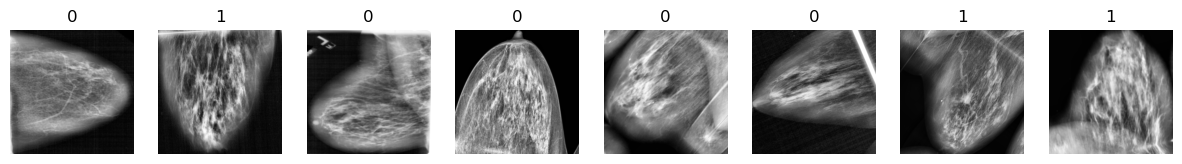

In [19]:
train_viz = DataLoader(train_dataset, batch_size=1, shuffle=True)

plt.figure(figsize=(15, 15))
for i, (img, label) in enumerate(train_viz):
    plt.subplot(1,8,i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
    plt.title(label.item())
    if i == 7:
        break

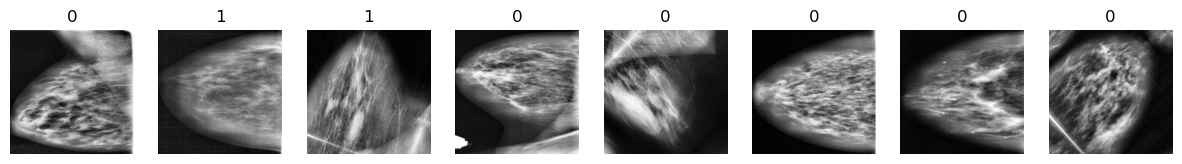

In [20]:
test_viz = DataLoader(test_dataset, batch_size=1, shuffle=True)

plt.figure(figsize=(15, 15))
for i, (img, label) in enumerate(test_viz):
    plt.subplot(1,8,i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
    plt.title(label.item())
    if i == 7:
        break

In [21]:
%mkdir /kaggle/working/model

In [22]:
!pip install wandb
import wandb
!wandb login 5ea6bd91c3e49f50e2842e8fc29f928eb0f5cd82
wandb.init(project="HRNET_FinalTest", entity="breast-cancer-kltn", name="final_test")

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: truongthicamly1412 (breast-cancer-kltn). Use `wandb login --relogin` to force relogin


In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
# train
tmp = 0
for epoch in range(100):
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    for i, inp in enumerate(train_loader, 0):
        inputs, labels = inp
        inputs, labels = data_to_device(inputs, labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        total_samples += len(labels)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        if i % 10 == 5:
            train_acc = running_corrects / total_samples
            train_loss = running_loss / 100
            print(f"[Epoch {epoch + 1}, Batch {i }] loss: {train_loss:.3f}, acc: {train_acc:.3f}")
            wandb.log({'loss':train_loss, 'accuracy':train_acc})
            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

    # Calculate F1-score, recall, and precision
    report = classification_report(all_labels, all_preds, output_dict=True)
    f1_score = report['weighted avg']['f1-score']
    recall = report['weighted avg']['recall']
    precision = report['weighted avg']['precision']
    wandb.log({'f1-score':f1_score, 'recall':recall, 'precision':precision})
    if f1_score > tmp:
        tmp = f1_score
        # Step 5: Save your trained model
        torch.save(model.state_dict(), "/kaggle/working/model/HRnet_DDSM_Inbreast.pt")

[Epoch 1, Batch 5] loss: 0.071, acc: 0.526
[Epoch 1, Batch 15] loss: 0.066, acc: 0.588
[Epoch 1, Batch 25] loss: 0.070, acc: 0.566
[Epoch 1, Batch 35] loss: 0.088, acc: 0.559
[Epoch 1, Batch 45] loss: 0.070, acc: 0.606
[Epoch 1, Batch 55] loss: 0.067, acc: 0.644
[Epoch 1, Batch 65] loss: 0.061, acc: 0.659
[Epoch 1, Batch 75] loss: 0.063, acc: 0.619
[Epoch 1, Batch 85] loss: 0.061, acc: 0.650
[Epoch 1, Batch 95] loss: 0.069, acc: 0.641
[Epoch 1, Batch 105] loss: 0.069, acc: 0.637
[Epoch 1, Batch 115] loss: 0.061, acc: 0.666
[Epoch 1, Batch 125] loss: 0.080, acc: 0.647
[Epoch 1, Batch 135] loss: 0.079, acc: 0.550
[Epoch 1, Batch 145] loss: 0.066, acc: 0.647
[Epoch 1, Batch 155] loss: 0.069, acc: 0.647
[Epoch 1, Batch 165] loss: 0.069, acc: 0.566
[Epoch 1, Batch 175] loss: 0.065, acc: 0.666
[Epoch 1, Batch 185] loss: 0.067, acc: 0.616
[Epoch 1, Batch 195] loss: 0.066, acc: 0.675
[Epoch 1, Batch 205] loss: 0.068, acc: 0.634
[Epoch 2, Batch 5] loss: 0.040, acc: 0.646
[Epoch 2, Batch 15] los

In [24]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
def test_acc(dataset, data_name):
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for data in dataset:
            images, labels = data
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            predicted = torch.argmax(probabilities, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(data_name)
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(cm)

    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    # Print the results
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

In [25]:
test_acc(train_loader, 'Dataset Train')

Dataset Train
Accuracy: 74.37%
Confusion Matrix:
[[3737  605]
 [1145 1341]]
Precision: 0.6891058581706063
Recall: 0.5394207562349155
F1-score: 0.6051444043321299


In [26]:
test_acc(test_loader, 'Dataset Test')

Dataset Test
Accuracy: 71.20%
Confusion Matrix:
[[908 180]
 [313 311]]
Precision: 0.6334012219959266
Recall: 0.4983974358974359
F1-score: 0.557847533632287


In [27]:
test_acc(ddsm_loader, 'DDSM Dataset Train')

DDSM Dataset Train
Accuracy: 73.43%
Confusion Matrix:
[[3443  630]
 [1029 1143]]
Precision: 0.6446700507614214
Recall: 0.5262430939226519
F1-score: 0.5794676806083651


In [28]:
test_acc(test_ddsm, 'DDSM Dataset Test')

DDSM Dataset Test
Accuracy: 72.49%
Confusion Matrix:
[[856 163]
 [267 277]]
Precision: 0.6295454545454545
Recall: 0.5091911764705882
F1-score: 0.5630081300813008


In [29]:
test_acc(mias_loader, 'Mias Dataset Train')

Mias Dataset Train
Accuracy: 71.09%
Confusion Matrix:
[[175  41]
 [ 33   7]]
Precision: 0.14583333333333334
Recall: 0.175
F1-score: 0.15909090909090912


In [30]:
test_acc(test_mias, 'Mias Dataset Test')

Mias Dataset Test
Accuracy: 66.67%
Confusion Matrix:
[[44 11]
 [11  0]]
Precision: 0.0
Recall: 0.0
F1-score: 0.0


In [31]:
test_acc(inbreast_loader, 'Inbreast Dataset Train')

Inbreast Dataset Train
Accuracy: 50.00%
Confusion Matrix:
[[30 23]
 [38 31]]
Precision: 0.5740740740740741
Recall: 0.4492753623188406
F1-score: 0.5040650406504064


In [32]:
test_acc(test_inbreast, 'Inbreast Dataset Test')

Inbreast Dataset Test
Accuracy: 42.17%
Confusion Matrix:
[[ 8  6]
 [42 27]]
Precision: 0.8181818181818182
Recall: 0.391304347826087
F1-score: 0.5294117647058824


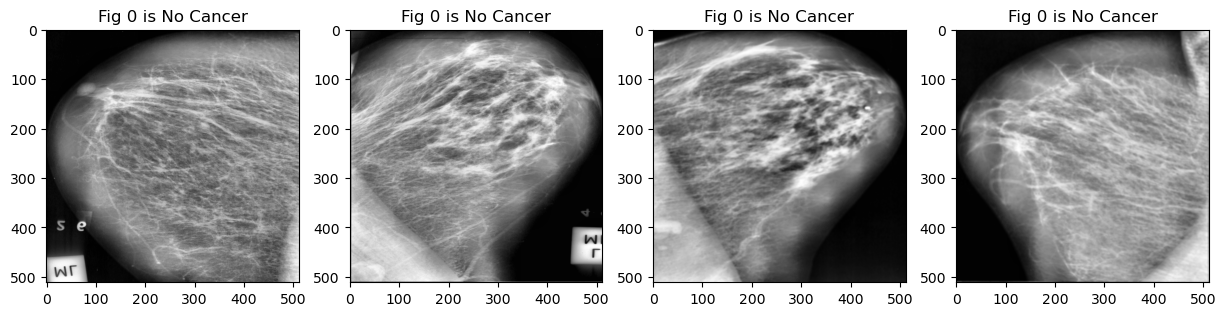

In [33]:
classes = ['No Cancer','Cancer']
list_pred_id=[]
list_pred_cancer=[]
model.eval()
with torch.no_grad():
    fig,ax = plt.subplots(1,4,figsize=(15,15))
    for k,(img_test,pred_id) in enumerate(test_dataset):
        ax_idx = ax[k]
        ax_idx.imshow(img_test.permute(1,2,0),cmap=plt.cm.gray)
        pred = model(img_test.type(torch.cuda.FloatTensor).unsqueeze(0))
        softmax=nn.Softmax(dim=1)
        final_pred = softmax(pred)
        predicted = classes[final_pred[0].argmax(0)]
        list_pred_id.append(pred_id)
        list_pred_cancer.append(final_pred[0].argmax(0).item())
        ax_idx.set_title(f"Fig {pred_id} is {predicted}")
        if k == 3:
            break
